# Behavior Transformer Implementation Walkthrough
Adapted from the original BeT code (https://github.com/notmahi/bet) and paper (https://arxiv.org/pdf/2206.11251)

**Libraries Required**

In [1]:
import torch
import torch.nn as nn

import torch.nn.functional as F
from gpt import GPT, GPTConfig
from sklearn.cluster import KMeans

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. K-Means Based (De/En)coder: $ a:= A_{\lfloor a \rfloor}$ + $ \langle a \rangle$
The first component of a Behavior Transformer (BeT) is a K-means based encoder and decoder learned prior to the task training and testing.

<img width="600px" src="images/K-Mean.png">

### **Encoder:** Given an action $a$, the ecnoder component would discretize it into an action bin **$\lfloor a \rfloor$** and a residual action **$ \langle a \rangle $**, such that $ a := A_{\lfloor a \rfloor} + \langle a \rangle $.

**Decoder:** Given an action bin **$\lfloor a \rfloor$** and the residual action **$ \langle a \rangle $**, it would output **a** given by $ a := A_{\lfloor a \rfloor} + \langle a \rangle $.

In [2]:
class EncoderDecoder:

    def __init__(self, action_dim, num_bins, actions):
        self.action_dim = action_dim
        self.num_bins = num_bins
        # Note: Using sklearn for simplicity
        self.kmeans = KMeans(n_clusters=self.num_bins) 
        self.kmeans.fit(actions.cpu())

    def encode(self, action):

        batch_size, sequence_length, action_dim = action.shape

        # Reshaping to exclude batch size        
        action = action.reshape((batch_size*sequence_length,action_dim))
        
        # Finding the action bin center
        action_bin = self.kmeans.predict(action.cpu())
        action_center = self.get_center(action_bin)

        # Computing the action residual (action - action_center)
        action_residual = action.to(DEVICE) - action_center.to(DEVICE)

        # Reshaping to include batch size
        action_residual = action_residual.reshape((batch_size, sequence_length, action_dim))
        action_bin = action_bin.reshape((batch_size, sequence_length, 1))

        # Returning the Action Bin and the Action Residual
        return torch.tensor(action_bin,dtype=torch.int64), action_residual.to(torch.float)
        
    def decode(self, action_bin, action_residual):
        action_center = self.get_center(action_bin.cpu()).to(DEVICE)
        action = action_residual + action_center
        # Returning the associated action
        return action
    
    def get_center(self, action_bin):
        return torch.tensor(self.kmeans.cluster_centers_[action_bin].squeeze())


**Tesing the Encoder/Decoder Component**

In [3]:
num_bins = 2
batch_size = 1
total_action_batch_size = 5
sequence_length = 2
action_dim = 2
total_actions = 3

actions = torch.rand((total_actions,action_dim))

encoder_decoder = EncoderDecoder(action_dim,num_bins,actions)

test_input = torch.rand((batch_size,sequence_length,action_dim))
action_bin, action_residual = encoder_decoder.encode(test_input) # Expected Output is a [1.0, 2.0] residual
print("Encoded Action Bin Shape:\t", action_bin.shape)
print("Encoded Action Residual Shape:\t", action_residual.shape)
decoded = encoder_decoder.decode(action_bin=action_bin,action_residual=action_residual)
print("Original:\t", test_input.cpu().numpy().tolist())
print("Decoded Action:\t", decoded.cpu().numpy().tolist())

Encoded Action Bin Shape:	 torch.Size([1, 2, 1])
Encoded Action Residual Shape:	 torch.Size([1, 2, 2])
Original:	 [[[0.7842819690704346, 0.7286837100982666], [0.6952674388885498, 0.7302123308181763]]]
Decoded Action:	 [[[0.7842819690704346, 0.728683739900589], [0.6952674388885498, 0.7302123606204987]]]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.8 is maybe too old for this OS.
  warnings.warn(


# 2. nanoGPT for initial Action Bins $\lfloor a \rfloor$
The second component of BeT is a transformer that takes the history of the last $L$ observations $[o_{i-L}, ... o_{i-1}, o_i]$ as an input, and outputs an initial predicted probability sequence of the fixed possible action bins of the next predicted action to get $\lfloor a_{i+1} \rfloor$. These will be used later to output the actual action bins logits.

<img width="700px" src="images/mingpt.jpeg">

In [4]:
def make_gpt(observation_dim, num_bins, sequence_length):
    gpt = GPT(GPTConfig(
        block_size=sequence_length,
        input_dim=observation_dim,
        output_dim=num_bins,
        n_layer=4,
        n_head=4,
        n_embd=72, 
    ))
    return gpt

**Tesing the GPT**

In [5]:
observation_dim = 1
num_bins = 10
sequence_length = 5
gpt = make_gpt(observation_dim,num_bins,sequence_length)
batch_size = 1

observations_history = torch.rand((batch_size,sequence_length,observation_dim))
logits = gpt(observations_history)

print("Observation Shape:\t\t", observations_history.shape)
print("Action Bins Logits Shape:\t", logits.shape)


number of parameters: 0.25M
Observation Shape:		 torch.Size([1, 5, 1])
Action Bins Logits Shape:	 torch.Size([1, 5, 10])


# 3. Transformer Head for final Action Residuals $ \langle a \rangle $ and Bins $\lfloor a \rfloor$
The last component of BeT takes the action bins $\lfloor a \rfloor$ logits outputed by the transformer and embeds them into a representation that includes the final action bin $\lfloor a \rfloor$ and action residual $ \langle a \rangle $

<img width="700px" src="images/head.jpeg">

In [6]:
class Head(nn.Module):

    def __init__(self, num_bins, action_dim, drop_out=0.1):
        super(Head, self).__init__()

        self.num_bins = num_bins
        self.action_dim = action_dim

        linear_in_dim = num_bins
        linear_out_dim = num_bins*(action_dim+1)
        
        self.layer = nn.Linear(linear_in_dim,linear_out_dim)
        self.dropout = nn.Dropout(drop_out)
       
    def forward(self, transformer_logits):
        
        batch_size, sequence_length, num_bins = transformer_logits.shape
        # Transformer Logits: (Batch_Size , Sequence_Length , Number_Action_Bins)

        x = self.layer(transformer_logits)
        action_data = self.dropout(x)
        # Action Data: (Batch_Size , Sequence_Length , Number_Action_Bins*(Action_dim+1))

        seq_action_bins_logits, all_seq_action_residuals = torch.split(action_data, [num_bins, num_bins * action_dim], dim=-1)
        # Sequence Action Bins Logits:   (Batch_Size , Sequence_Length, Number_Action_Bins)
        # All Sequence Action Residuals: (Batch_Size , Sequence_Length, Number_Action_Bins*Action_dim)
        
        # Softmaxing the seq_action_bins_logits action bins logits to get the probability per bin at every sequence index
        seq_action_bins_probs = torch.softmax(seq_action_bins_logits,dim=-1)
        seq_action_bins = torch.multinomial(seq_action_bins_probs.view(-1, num_bins), num_samples=1)
        seq_action_bins = seq_action_bins.reshape((batch_size,sequence_length,1))
        # Sequence Action Bins: (Batch_Size, Sequence_Length, 1)

        # Keeping the action resiudals for the selected action bin
        flat_all_seq_action_residuals = all_seq_action_residuals.reshape((batch_size*sequence_length, num_bins, action_dim))
        flat_seq_action_residuals = flat_all_seq_action_residuals[torch.arange(flat_all_seq_action_residuals.shape[0]),seq_action_bins.flatten()]
        seq_action_residuals = flat_seq_action_residuals.reshape((batch_size, sequence_length, action_dim))
        # Sequence Action Residuals: (Batch_Size , Sequence_Length, Action_dim)

        return {"seq_action_bins": seq_action_bins, "seq_action_residuals": seq_action_residuals, "seq_action_bins_logits": seq_action_bins_logits,}

**Tesing the Transformer Head**

In [7]:
batch_size = 5
num_bins = 2
sequence_length = 5
action_dim = 3
logits = torch.rand((batch_size,sequence_length,num_bins))

head = Head(num_bins,action_dim)
output = head(logits)
seq_action_bins, seq_action_residuals, seq_action_bins_logits = output["seq_action_bins"], output["seq_action_residuals"], output["seq_action_bins_logits"]

print("Action Residuals Shape:\t\t", seq_action_residuals.shape)
print("Actions Bins Shape:\t\t", seq_action_bins.shape)
print("Actions Bins Logits Shape:\t", seq_action_bins_logits.shape)

Action Residuals Shape:		 torch.Size([5, 5, 3])
Actions Bins Shape:		 torch.Size([5, 5, 1])
Actions Bins Logits Shape:	 torch.Size([5, 5, 2])


# 4. Focal Loss for Action Bins $\lfloor a \rfloor$

$L_{focal}(p_t) = -(1 - p_t)^\gamma \log(p_t)$

Focal loss is used to handle the class imbalance in action bins by assigning more weight for hard-to-classify examples inorder to be improve performance in predicting low-probability classes (important for multi-modal behavior distributions​​).

<img width="700px" src="images/loss.jpeg">

In [8]:
# Source: https://github.com/notmahi/miniBET/blob/main/behavior_transformer/bet.py

class FocalLoss(nn.Module):

    def __init__(self, gamma: float = 0, size_average: bool = True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.size_average = size_average

    def forward(self, input, target):
        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1, target.view(-1, 1)).view(-1)
        pt = logpt.exp()

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

# 5. Multi-Task (MT) Loss for Action Residuals $\langle a \rangle$

The multi-task loss is calculated using only the action residuals associated to the choosen action bins at every step in the sequence. It is implemented directly as part of the learn() function in the BeT class down below

# 6. BeT: Stitching all the Componenets Together 

Here, we combine the k-means based encoder/decoder, GPT, and head that we implemented earlier. Additionally, a training function for calculating the losses was added. 

<img width="1000px" src="images/bet.jpeg">

In [9]:
class BeT(nn.Module):

    def __init__(self, observation_dim, action_dim, num_bins, sequence_length, actions, gamma=2.0):
        super(BeT, self).__init__()

        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.num_bins = num_bins
        self.sequence_length = sequence_length
        
        # Initializing the Encoder Decoder which is based on the K-Means
        self.encoderDecoder = EncoderDecoder(action_dim, num_bins, actions)

        # Initializing the GPT model to be used for sequence to sequence modeling
        self.gpt = make_gpt(observation_dim,num_bins,sequence_length).to(DEVICE)
        
        # Initializing the Head that takes the sequence output of the GPT to return the action bin and action residual
        self.head = Head(num_bins, action_dim).to(DEVICE)

        # Residual Loss Function 
        self.residual_criterion = nn.MSELoss()

        # Action Bins Loss Function 
        self.bin_criterion = FocalLoss(gamma)

    def forward(self, observations_history, train_data=False):
        
        # (Batch Size, Sequence Lenght, Number of Action Bins)
        gpt_logits = self.gpt(observations_history)

        head_output = self.head(gpt_logits)
        # Predicted Sequence Action Bins: (Batch_Size, Sequence_Length, 1)
        predicted_seq_action_bins = head_output["seq_action_bins"]
        # Predicted Sequence Action Residuals: (Batch_Size, Sequence_Length, Action_dim)
        predicted_seq_action_residuals = head_output["seq_action_residuals"]
        # Predicted Sequence Action Bins Logits: (Batch_Size, Sequence_Length, Number_Action_Bins)
        seq_action_bins_logits = head_output["seq_action_bins_logits"]

        # Predicted Action: (Batch_Size, Action_dim)
        predicted_action = self.encoderDecoder.decode(predicted_seq_action_bins[:,-1,0],predicted_seq_action_residuals[:,-1,:])

        # No Training: Inference Only (No Loss Calculation)
        if not train_data:
            return predicted_action
        # Training: Return Predicted Action and Training Required Data
        else:
            return {"seq_action_bins_logits":seq_action_bins_logits, "predicted_seq_action_residuals":predicted_seq_action_residuals}

    def learn(self, observations_history, actions_history, optimizer, residual_loss_scale=1e3, eval=False):
        
        # Target Sequence Action Bins: (Batch_Size, Sequence_Length, Number_Action_Bins)
        # Target Sequence Action Residuals: (Batch_Size, Sequence_Length, Action_Dims)
        target_seq_action_bin, target_seq_action_residuals = self.encoderDecoder.encode(actions_history)

        training_data = self.forward(observations_history, train_data=True)
        # Predicted Sequence Action Residuals: (Batch_Size, Sequence_Length, Action_dim)
        predicted_seq_action_residuals = training_data["predicted_seq_action_residuals"]
        # Predicted Sequence Action Bins Logits: (Batch_Size, Sequence_Length, Number_Action_Bins)
        seq_action_bins_logits = training_data["seq_action_bins_logits"]

        # Residual Loss
        action_residual_loss = self.residual_criterion(predicted_seq_action_residuals, target_seq_action_residuals)*residual_loss_scale

        # Actions Bin Loss
        seq_action_bins_logits = seq_action_bins_logits.reshape((-1,seq_action_bins_logits.shape[-1])).to(DEVICE)
        target_seq_action_bin = target_seq_action_bin.reshape((-1,1)).to(DEVICE)
        action_bins_loss = self.bin_criterion(seq_action_bins_logits, target_seq_action_bin)

        # Total Loss = Actions Bin Loss + Residual Loss * Loss Scale
        total_loss = action_bins_loss + action_residual_loss
        
        if eval == False:
            # Training Step
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
            optimizer.step()

        return {"total_loss": total_loss, "action_bins_loss": action_bins_loss, "action_residual_loss": action_residual_loss}
    
    # Source: https://github.com/notmahi/miniBET/blob/main/behavior_transformer/bet.py
    def create_optimizer(self, weight_decay, learning_rate, betas):
        optimizer = self.gpt.configure_optimizers(
            weight_decay=weight_decay,
            learning_rate=learning_rate,
            betas=betas,
        )
        optimizer.add_param_group({"params": self.head.parameters()})
        return optimizer

**Testing the BeT Combined Componenet**

In [10]:
num_bins = 2
batch_size = 2
total_action_batch_size = 5
sequence_length = 10
action_dim = 3
total_actions = 100

actions_collection = torch.rand((total_actions,action_dim)).to(DEVICE)
bet = BeT(observation_dim, action_dim, num_bins, sequence_length, actions_collection).to(DEVICE)

observations_history = torch.rand((batch_size,sequence_length,observation_dim)).to(DEVICE)
predicted_action = bet(observations_history)
print("Action Shape: ", predicted_action.shape)

number of parameters: 0.25M
Action Shape:  torch.Size([2, 3])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


**Training Test**

In [11]:
bet_optimizer = bet.create_optimizer(weight_decay=0.2,learning_rate=0.01,betas=[0.9,0.999])

observations_history = torch.rand((batch_size,sequence_length,observation_dim)).to(DEVICE)
actions_history = torch.rand((batch_size,sequence_length,action_dim)).to(DEVICE)
bet.learn(observations_history, actions_history, bet_optimizer)

{'total_loss': tensor(328.9534, grad_fn=<AddBackward0>),
 'action_bins_loss': tensor(0.1941, grad_fn=<MeanBackward0>),
 'action_residual_loss': tensor(328.7593, grad_fn=<MulBackward0>)}

# Multimodal Block Pushing Example Demo

<img width="700px" src="images/block_push.png">

**Importing Required Libraries**

In [12]:
import gin
import pybullet
import numpy as np
import os
import gym
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

gin.enter_interactive_mode()
from envs.block_pushing.block_pushing_multimodal import BlockPushMultimodal
os.environ['ASSET_PATH'] = 'envs/assets'

pybullet build time: Feb  1 2024 15:45:34


**Importing Play Data**

In [13]:
action_history = torch.tensor(np.load("envs/block_pushing_data/multimodal_push_actions.npy")).to(torch.float).to(DEVICE)
observation_history = torch.tensor(np.load("envs/block_pushing_data/multimodal_push_observations.npy")).to(torch.float).to(DEVICE)
observation_masks = torch.tensor(np.load("envs/block_pushing_data/multimodal_push_masks.npy")).to(torch.float).to(DEVICE)
all_actions = action_history.reshape((-1,action_history.shape[2])) # To fit the decoder/encoder

print("Action History:\t\t", action_history.shape)
print("Observations History:\t", observation_history.shape)
print("Masks History:\t\t", observation_masks.shape)
print("All Actions:\t\t", all_actions.shape)


Action History:		 torch.Size([1000, 201, 2])
Observations History:	 torch.Size([1000, 201, 16])
Masks History:		 torch.Size([1000, 201])
All Actions:		 torch.Size([201000, 2])


**Block Pushing Dataset**

In [14]:
class BlockPushingDataset(Dataset):
    def __init__(self, action_history, observation_history, observation_masks, context=5):
        self.action_history = action_history
        self.observation_history = observation_history
        self.observation_masks = observation_masks
        self.context = context
        
        self.valid_indices = self._generate_valid_indices()

        print("Number of Valid Points: ", len(self.valid_indices))
        
    def _generate_valid_indices(self):
        valid_indices = []
        for idx in range(len(self.action_history)):
            for start in range(self.action_history.shape[1] - self.context + 1):
                if all(self.observation_masks[idx, start:start + self.context]):
                    valid_indices.append((idx, start))
        return valid_indices
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        seq_idx, start = self.valid_indices[idx]
        
        action_seq = self.action_history[seq_idx, start:start + self.context]
        observation_seq = self.observation_history[seq_idx, start:start + self.context]

        return action_seq, observation_seq

In [15]:
batch_size = 64

dataset = BlockPushingDataset(action_history, observation_history, observation_masks, context=5)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Number of Valid Points:  112793


**Setting up the Model**

In [16]:
observation_dim = 16
action_dim = 2
num_bins = 24
sequence_length = 5
dataset_size = 1000

bet = BeT(observation_dim, action_dim, num_bins, sequence_length, all_actions).to(DEVICE)
optimizer = bet.create_optimizer(weight_decay=0.1,learning_rate=1e-4,betas=[0.9,0.999])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


number of parameters: 0.26M


In [17]:
epochs = 350

train_loss_history = []
test_loss_history = []

train_bin_loss_history = []
train_residual_loss_history = []

test_bin_loss_history = []
test_residual_loss_history = []

for epoch in range(epochs):
    
    train_loss = 0.0
    test_loss = 0.0
    train_bins_loss = 0.0
    train_residual_loss = 0.0
    test_bins_loss = 0.0
    test_residual_loss = 0.0
    
    total_train_idx = 0
    total_test_idx = 0

    for actions_sequence, observations_sequence in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        
        total_train_idx += actions_sequence.shape[0]

        actions_sequence = actions_sequence.to(DEVICE)
        observations_sequence = observations_sequence.to(DEVICE)

        losses = bet.learn(observations_sequence, actions_sequence, optimizer)

        total_loss = losses["total_loss"].item()
        action_bins_loss = losses["action_bins_loss"].item()
        action_residual_loss = losses["action_residual_loss"].item()

        train_loss += total_loss
        train_bins_loss += action_bins_loss
        train_residual_loss += action_residual_loss

    for actions_sequence, observations_sequence in test_loader:

        total_test_idx += actions_sequence.shape[0]

        actions_sequence = actions_sequence.to(DEVICE)
        observations_sequence = observations_sequence.to(DEVICE)

        losses = bet.learn(observations_sequence, actions_sequence, optimizer, eval=True)

        total_loss = losses["total_loss"].item()
        action_bins_loss = losses["action_bins_loss"].item()
        action_residual_loss = losses["action_residual_loss"].item()

        test_loss += total_loss
        test_bins_loss += action_bins_loss
        test_residual_loss += action_residual_loss
    
    train_loss_history.append(train_loss/total_train_idx)
    test_loss_history.append(test_loss/total_test_idx)

    train_bin_loss_history.append(train_bins_loss/total_train_idx)
    train_residual_loss_history.append(train_residual_loss/total_train_idx)

    test_bin_loss_history.append(test_bins_loss/total_test_idx)
    test_residual_loss_history.append(test_residual_loss/total_test_idx)

    
    print(f"Total Train Loss: {train_loss/total_train_idx:.4f} (Bins Loss: {train_bins_loss/total_train_idx:.4f}, Residuals Loss: {train_residual_loss/total_train_idx:.4f}")
    print(f"Total Test Loss:  {test_loss/total_test_idx:.4f} (Bins Loss: {test_bins_loss/total_test_idx:.4f}, Residuals Loss: {test_residual_loss/total_test_idx:.4f}")

    # Saving Checkpoint
    
    np_test_loss_history = np.array(test_loss_history)
    np_train_loss_history = np.array(train_loss_history)
    np_test_bin_loss_history = np.array(test_bin_loss_history)
    np_train_bin_loss_history = np.array(train_bin_loss_history)
    np_test_residual_loss_history = np.array(test_residual_loss_history)
    np_train_residual_loss_history = np.array(train_residual_loss_history)
    
    np.save("checkpoint/test_loss_history.npy",np_test_loss_history)
    np.save("checkpoint/train_loss_history.npy",np_train_loss_history)
    np.save("checkpoint/test_bin_loss_history.npy",np_test_bin_loss_history)
    np.save("checkpoint/train_bin_loss_history.npy",np_train_bin_loss_history)
    np.save("checkpoint/test_residual_loss_history.npy",np_test_residual_loss_history)
    np.save("checkpoint/train_residual_loss_history.npy",np_train_residual_loss_history)
    torch.save({'model_state_dict': bet.state_dict(),}, "checkpoint/block_pushing_checkpoint")

In [18]:
test_loss_history = np.load("checkpoints/test_loss_history.npy")
train_loss_history = np.load("checkpoints/train_loss_history.npy")
test_bin_loss_history = np.load("checkpoints/test_bin_loss_history.npy")
train_bin_loss_history = np.load("checkpoints/train_bin_loss_history.npy")
test_residual_loss_history = np.load("checkpoints/test_residual_loss_history.npy")
train_residual_loss_history = np.load("checkpoints/train_residual_loss_history.npy")

import pickle
with open('checkpoints/bet.pkl', 'rb') as f:
    bet = pickle.load(f)

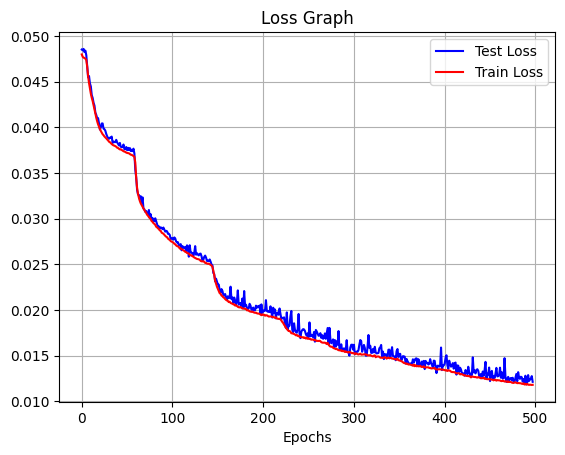

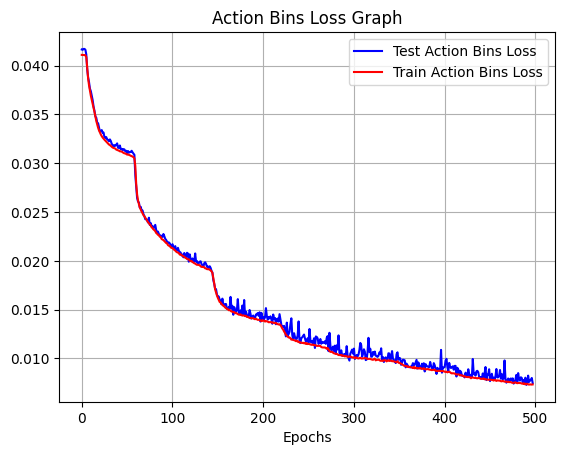

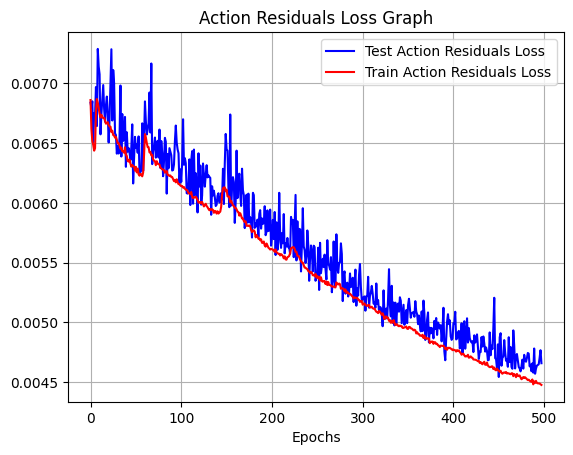

In [19]:
plt.figure()
plt.plot(test_loss_history[2:],'b')
plt.plot(train_loss_history[2:],'r')
plt.grid(True)
plt.title("Loss Graph")
plt.xlabel("Epochs")
plt.legend(["Test Loss","Train Loss"])

plt.figure()
plt.plot(test_bin_loss_history[2:],'b')
plt.plot(train_bin_loss_history[2:],'r')
plt.grid(True)
plt.title("Action Bins Loss Graph")
plt.xlabel("Epochs")
plt.legend(["Test Action Bins Loss","Train Action Bins Loss"])

plt.figure()
plt.plot(test_residual_loss_history[2:],'b')
plt.plot(train_residual_loss_history[2:],'r')
plt.grid(True)
plt.title("Action Residuals Loss Graph")
plt.xlabel("Epochs")
plt.legend(["Test Action Residuals Loss","Train Action Residuals Loss"])

**Human Rendered Pybullet Evaluation**

In [ ]:
import matplotlib
matplotlib.use('TkAgg')  # Use TkAgg backend

import gym
import numpy as np
import torch

# Create the environment
env = gym.make("BlockPushMultimodal-v0")

# Ensure bet is defined and in evaluation mode
# bet should be your model
# bet = YourModel()
bet.eval()

# Function to pad an observation to 16 values with zeros
def pad_observation(obs, target_length=16):
    flattened_obs = np.hstack([np.array(value).flatten() for value in list(obs.values())])
    if len(flattened_obs) < target_length:
        padded_obs = np.pad(flattened_obs, (0, target_length - len(flattened_obs)), 'constant')
    else:
        padded_obs = flattened_obs[:target_length]
    return padded_obs


# Initialize the environment and variables
observation = env.reset()
observation_history = torch.zeros((5, 16))

step_count = 0
while True:  # Use the done variable to break the loop

    padded_observation = pad_observation(observation)
    step_count += 1

    # Update the observation history tensor
    if step_count <= 5:
        observation_history[step_count - 1] = torch.tensor(padded_observation, dtype=torch.float)
    else:
        observation_history = torch.cat((observation_history[1:], torch.tensor(padded_observation, dtype=torch.float).unsqueeze(0)), dim=0)
    
    action = bet(observation_history.view((1,5,16))).detach().cpu().numpy()[0]
    observation, reward, done, info = env.step(action)

    if done:
        observation = env.reset()
        observation_history = torch.zeros((5, 16))
        step_count = 0
    
    # Render the environment
    env.render()

env.close()
